# installs and imports

In [ ]:
!pip install ydata_profiling
!pip install -U tf2onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.5/359.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=cf7b669f76a5dbde225e2b07a0dc87e2012045c38321b36376be11e37d87a2e3
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import onnxruntime as rt
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import roc_curve, auc,confusion_matrix, ConfusionMatrixDisplay

# Datasets

In [ ]:
csv_files=['/content/a_la_carte_0ba217f.csv']
df = pd.read_csv(csv_files[0],index_col=0)


df_as_heuristics_global_test_iqa_ok   = df[((df['batch'] == "as_heuristics_global_test_iqa_ok"))]
df_as_heuristics_ibeta_1_labeling_qa = df[((df['batch'] == "as_heuristics_ibeta_1_labeling_qa"))]
df_as_heuristics_celeba_spoofs_train= df[((df['batch'] == "as_heuristics_celeba_spoofs_train"))]

df_training=pd.concat([df_as_heuristics_global_test_iqa_ok,df_as_heuristics_ibeta_1_labeling_qa])
df_training=df_training[df_training['review']!='DEEP_FAKE']

df_test=pd.concat([df_as_heuristics_global_test_iqa_ok,df_as_heuristics_ibeta_1_labeling_qa,df_as_heuristics_celeba_spoofs_train])

#df_test=df_training

print(df.shape,df_training.shape,df_test.shape)

profile_report = ProfileReport(df_training, title="Pandas Profiling Report",explorative=True)
profile_report

(23161, 20) (5142, 20) (23161, 20)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Prepare inputs



In [ ]:
X = df_training[['ibeta1_exp_prob','ibeta1_crops_prob','ibeta1_clip_prob']]# Inputs
X_test = df_test[['ibeta1_exp_prob','ibeta1_crops_prob','ibeta1_clip_prob']]# Inputs

# correlation_matrix = X_test.corr(numeric_only=True)
# correlation_with_target = correlation_matrix['real'].sort_values(ascending=False)

# print(correlation_with_target)

# average_probs = X_test.mean()

# lowest_avg_probs = average_probs.nsmallest(3)

# print(lowest_avg_probs)

# highest_avg_probs = average_probs.nlargest(3)
# print(highest_avg_probs)

In [ ]:
def prepare_labels(df):
    """Encodes labels, performs one-hot encoding, and handles binary/multiclass cases."""
    df = df.copy()
    df['review'] = pd.Categorical(df['review'])
    label_mapping = dict(enumerate(df['review'].cat.categories))
    df['labels'] = df['review'].cat.codes
    return label_mapping, df

# Prepare labels
label_mapping, df_training = prepare_labels(df_training)
label_mapping_test, df_test = prepare_labels(df_test)

print("\nLabel mapping:", label_mapping_test)

# Extract the labels
y = df_training['labels']
y_test = df_test['labels']

# Check distribution of labels before split
print("\n Training label distribution before split:\n", y.value_counts(normalize=False))



Label mapping: {0: 'DEEP_FAKE', 1: 'MASK_2D', 2: 'MASK_2D_W_EYEHOLES', 3: 'MASK_3D', 4: 'PRINT', 5: 'REAL_PERSON', 6: 'REPLAY_ATTACK_MONITOR', 7: 'REPLAY_ATTACK_SMARTPHONE', 8: 'WRAPPED_2D_MASK'}

 Training label distribution before split:
 labels
3    3622
0     499
1     380
4     273
5     201
2     130
6      37
Name: count, dtype: int64


#Split dataset in train-val-test

In [ ]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y, shuffle=True)

# Split the test set
#X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val, shuffle=True)

# Check distribution of labels after split
print("\nLabel distribution in training set:\n", y_train.value_counts(normalize=False))
print("\nLabel distribution in validation set:\n", y_val.value_counts(normalize=False))
print("\nLabel distribution in test set:\n", y_test.value_counts(normalize=False))

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(X_train,y_train)


Label distribution in training set:
 labels
3    2173
0     299
1     228
4     164
5     121
2      78
6      22
Name: count, dtype: int64

Label distribution in validation set:
 labels
3    1449
0     200
1     152
4     109
5      80
2      52
6      15
Name: count, dtype: int64

Label distribution in test set:
 labels
3    4630
5    3623
1    3499
7    3201
4    3000
2    1880
6    1773
8    1537
0      18
Name: count, dtype: int64
(3085, 3) (3085,)
(2057, 3) (2057,)
(23161, 3) (23161,)
          ibeta1_exp_prob  ibeta1_crops_prob  ibeta1_clip_prob
api_hash                                                      
0ba217f          0.609713       5.279802e-02      9.943567e-01
0ba217f          0.000004       1.614327e-07      2.873753e-14
0ba217f          0.999803       9.871336e-01      9.999985e-01
0ba217f          0.905899       1.645846e-01      9.968737e-01
0ba217f          0.000081       2.597023e-07      1.105307e-13
...                   ...                ...               ...

In [ ]:
def binarize_and_count_labels(series, target_category=3):
    # Convert to binary: 1 if the label is the target category, 0 otherwise
    binary_labels = series.apply(lambda x: 1 if x == target_category else 0)

    # Count the number of zeros and ones
    count_zeros = sum(binary_labels == 0)
    count_ones = sum(binary_labels == 1)

    return binary_labels,count_zeros, count_ones


# Call the function with your DataFrame

target_category=5
y_train_binary,y_train_count_zeros,y_train_count_ones = binarize_and_count_labels(y_train)
y_val_binary,y_val_count_zeros,y_val_count_ones = binarize_and_count_labels(y_val)
y_test_binary,y_test_count_zeros,y_test_count_ones = binarize_and_count_labels(y_test,target_category=5)


print()
print(y_train_binary)
print(y_val_binary)
print(y_test_binary)
print()
print(y_train_count_zeros,y_train_count_ones)
print(y_val_count_zeros,y_val_count_ones)
print(y_test_count_zeros,y_test_count_ones)




api_hash
0ba217f    1
0ba217f    0
0ba217f    1
0ba217f    1
0ba217f    0
          ..
0ba217f    1
0ba217f    1
0ba217f    0
0ba217f    0
0ba217f    1
Name: labels, Length: 3085, dtype: int64
api_hash
0ba217f    1
0ba217f    0
0ba217f    1
0ba217f    1
0ba217f    1
          ..
0ba217f    1
0ba217f    1
0ba217f    1
0ba217f    1
0ba217f    1
Name: labels, Length: 2057, dtype: int64
api_hash
0ba217f    1
0ba217f    0
0ba217f    1
0ba217f    0
0ba217f    1
          ..
0ba217f    0
0ba217f    0
0ba217f    0
0ba217f    0
0ba217f    1
Name: labels, Length: 23161, dtype: int64

912 2173
608 1449
19538 3623


#Binary Training

In [ ]:
# Define the initial learning rate
initial_learning_rate = 0.001
# Define the learning rate schedule function
def lr_schedule(epoch):
    if epoch < 30:
        return initial_learning_rate
    elif epoch < 60:
        return initial_learning_rate * 1  # decrease the learning rate by 90%
    else:
        return initial_learning_rate *1   # decrease the learning rate by another 90%


# Create a LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule)

# Create the Adam optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_learning_rate)
optimizer_for_binary = Adam(learning_rate=initial_learning_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

binary_model = tf.keras.Sequential([
tf.keras.layers.Dense(X_train.shape[1]**2, input_dim=X_train.shape[1], activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])

binary_model.compile(loss='binary_crossentropy', optimizer=optimizer_for_binary, metrics=['AUC'])

#Metrics

In [ ]:
def plot_history(history):
  # Plot the training and validation loss
  plt.figure(figsize=(8, 6))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

def compute_roc_curve(y_test, y_pred):
  # Calculate ROC curve metrics
  fpr, tpr, thresholds = roc_curve(y_test, y_pred)
  for i in range(len(thresholds)):
    print(f"Threshold: {thresholds[i]}, TPR: {tpr[i]}, FPR: {fpr[i]}")
  roc_auc = auc(fpr, tpr)

  # Find the index of the best threshold
  best_idx = np.argmax(tpr * (1 - fpr))
  best_thresh = thresholds[best_idx]

  # Plot the ROC curve
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  # Mark the best point on the ROC curve
  plt.scatter(fpr[best_idx], tpr[best_idx], marker='o', color='red', label=f'Best Threshold: {best_thresh:.4f}')
  plt.legend()
  plt.show()
  return roc_auc,best_thresh

def compute_confusion_matrix(y_test, y_pred, best_thresh):
  # Make predictions on test data with the optimal threshold
  best_thresh=0.9532500505447388
  predictions = (y_pred > best_thresh).astype(int)
  cm = confusion_matrix(y_test, predictions)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()

def predict_model(model, X, y):
  y_pred = model.predict(X).ravel()
  roc_auc,best_thresh = compute_roc_curve(y, y_pred)
  compute_confusion_matrix(y, y_pred, best_thresh)
  return roc_auc,best_thresh



Epoch 1/100
1543/1543 [==============================] - 7s 4ms/step - loss: 0.2836 - auc: 0.9765 - val_loss: 0.1112 - val_auc: 0.9948 - lr: 0.0010
Epoch 2/100
1543/1543 [==============================] - 4s 3ms/step - loss: 0.1075 - auc: 0.9887 - val_loss: 0.0794 - val_auc: 0.9948 - lr: 0.0010
Epoch 3/100
1543/1543 [==============================] - 4s 3ms/step - loss: 0.1004 - auc: 0.9878 - val_loss: 0.0766 - val_auc: 0.9939 - lr: 0.0010
Epoch 4/100
1543/1543 [==============================] - 7s 4ms/step - loss: 0.0994 - auc: 0.9882 - val_loss: 0.0750 - val_auc: 0.9945 - lr: 0.0010
Epoch 5/100
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0993 - auc: 0.9892 - val_loss: 0.0748 - val_auc: 0.9939 - lr: 0.0010
Epoch 6/100
1543/1543 [==============================] - 5s 4ms/step - loss: 0.0991 - auc: 0.9894 - val_loss: 0.0745 - val_auc: 0.9939 - lr: 0.0010
Epoch 7/100
1543/1543 [==============================] - 4s 3ms/step - loss: 0.0985 - auc: 0.9893 - val_loss: 0.

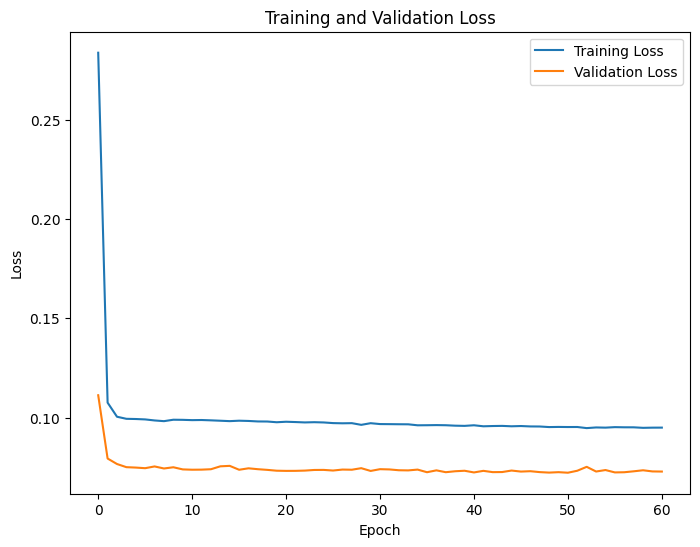

In [ ]:
# Train the model
binary_history = binary_model.fit(X_train, y_train_binary, validation_data=(X_val, y_val_binary), epochs=100, batch_size=2, callbacks=[early_stopping,lr_callback])# class_weight=class_weight_dict)
plot_history(binary_history)


724/724 [==============================] - 1s 1ms/step
Threshold: 1.994924783706665, TPR: 0.0, FPR: 0.0
Threshold: 0.9949247241020203, TPR: 0.0038642009384487995, FPR: 0.0
Threshold: 0.9949246644973755, TPR: 0.01269666022633177, FPR: 0.0
Threshold: 0.9949246048927307, TPR: 0.019321004692243997, FPR: 0.0
Threshold: 0.9949245452880859, TPR: 0.02649737786364891, FPR: 0.0
Threshold: 0.9949244856834412, TPR: 0.02953353574385868, FPR: 0.0
Threshold: 0.9949244260787964, TPR: 0.03422577974054651, FPR: 0.0
Threshold: 0.9949243664741516, TPR: 0.03781396632624896, FPR: 0.0
Threshold: 0.9949243068695068, TPR: 0.041678167264697766, FPR: 0.0
Threshold: 0.9949242472648621, TPR: 0.04499033949765388, FPR: 0.0
Threshold: 0.9949241876602173, TPR: 0.049406569141595365, FPR: 0.0
Threshold: 0.9949241280555725, TPR: 0.052442727021805136, FPR: 0.0
Threshold: 0.9949240684509277, TPR: 0.056582942313000276, FPR: 0.0
Threshold: 0.994924008846283, TPR: 0.05851504278222468, FPR: 0.0
Threshold: 0.9949239492416382, T

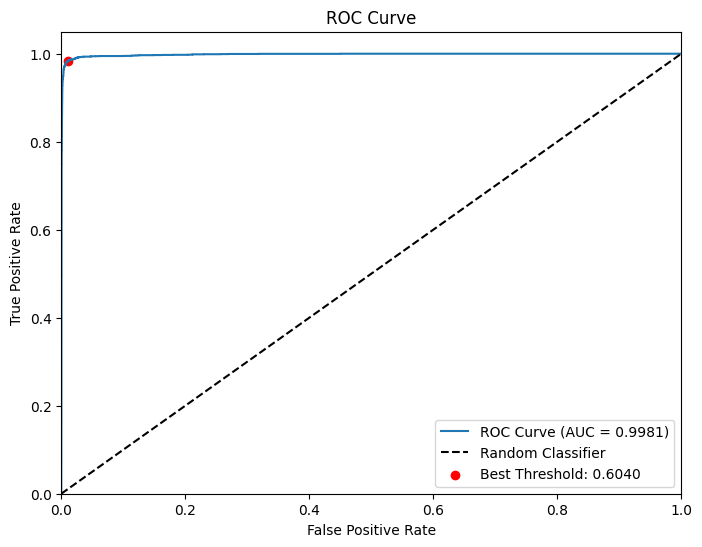

AUC: 0.9981
Best Threshold: 0.6039724946022034


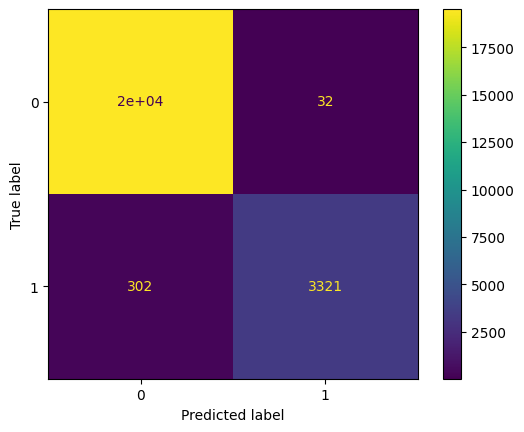

In [ ]:
# Predict model
binary_datasets = [(X_test, y_test_binary)]
for X, y in binary_datasets:
    roc_auc,best_thresh=predict_model(binary_model, X, y)
    print(f'AUC: {roc_auc:.4f}')
    print(f'Best Threshold: {best_thresh}')

In [ ]:
binary_model.save('perceptron_11.tf',save_format='tf')
!python -m tf2onnx.convert --saved-model perceptron_11.tf --output perceptron_11.onnx

sess = rt.InferenceSession("perceptron_11.onnx")
input_name = sess.get_inputs()[0].name
input_data = X_test.to_numpy(dtype=np.float32)
predictions = sess.run(None, {input_name: input_data})
df_test['perceptron_11'] = predictions[0]
df_test.head()
df_test.to_csv('df_test_perceptron_11.csv')



2024-06-11 21:29:16.811254: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 21:29:16.811357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 21:29:16.815118: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-11 21:29:19.360057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2